# Data Configuration

## Import packages

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
cd /gdrive/My Drive/img_dataset/img_dataset

/gdrive/My Drive/img_dataset/img_dataset


In [0]:
!pip install -q tf-nightly

In [7]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
import os

import numpy as np

import matplotlib.pyplot as plt

keras = tf.keras
tf.VERSION


'1.14.1-dev20190505'

## Data preprocessing

In [8]:
import pathlib
import os

data_root=pathlib.Path('/gdrive/My Drive/img_dataset/img_dataset/celebs')
print(data_root)

/gdrive/My Drive/img_dataset/img_dataset/celebs


In [9]:
for item in data_root.iterdir():
  print(item)

/gdrive/My Drive/img_dataset/img_dataset/celebs/Arnold_Schwarzenegger
/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush
/gdrive/My Drive/img_dataset/img_dataset/celebs/Junichiro_Koizumi
/gdrive/My Drive/img_dataset/img_dataset/celebs/Tony_Blair
/gdrive/My Drive/img_dataset/img_dataset/celebs/Vladimir_Putin


In [10]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

img_count = len(all_image_paths)
img_count

825

## Check the images

In [11]:
all_image_paths[:10]

['/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0514.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/Tony_Blair/Tony_Blair_0096.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0008.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0428.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0281.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0033.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/Junichiro_Koizumi/Junichiro_Koizumi_0009.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0011.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0108.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0530.jpg']

In [0]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image : " + ' - '.join(str(image_rel).split('-'))
    

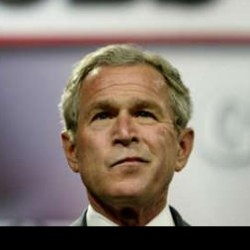

Image : George_W_Bush/George_W_Bush_0288.jpg



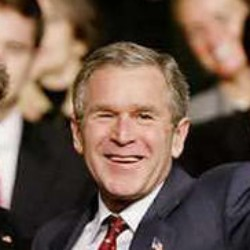

Image : George_W_Bush/George_W_Bush_0221.jpg



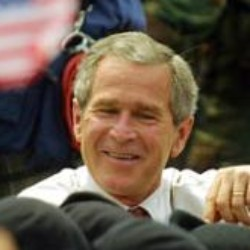

Image : George_W_Bush/George_W_Bush_0065.jpg



In [13]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [14]:
label_names= sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Arnold_Schwarzenegger',
 'George_W_Bush',
 'Junichiro_Koizumi',
 'Tony_Blair',
 'Vladimir_Putin']

In [15]:
label_to_index = dict((name,index)for index,name in enumerate(label_names))
label_to_index

{'Arnold_Schwarzenegger': 0,
 'George_W_Bush': 1,
 'Junichiro_Koizumi': 2,
 'Tony_Blair': 3,
 'Vladimir_Putin': 4}

In [17]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                   for path in all_image_paths]

print("First 10 labels indices : ", all_image_labels[:10])

First 10 labels indices :  [1, 3, 1, 1, 1, 0, 2, 1, 1, 1]


In [18]:
img_path = all_image_paths[0]
img_path

'/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0514.jpg'

In [19]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [20]:
img_tensor =tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(250, 250, 3)
<dtype: 'uint8'>


In [21]:
img_final = tf.image.resize_images(img_tensor, [224, 224])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(224, 224, 3)
0.0
1.0


In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize_images(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

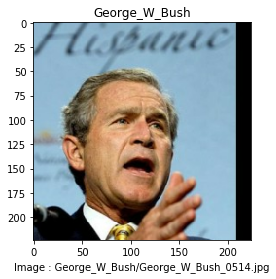

In [24]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [27]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

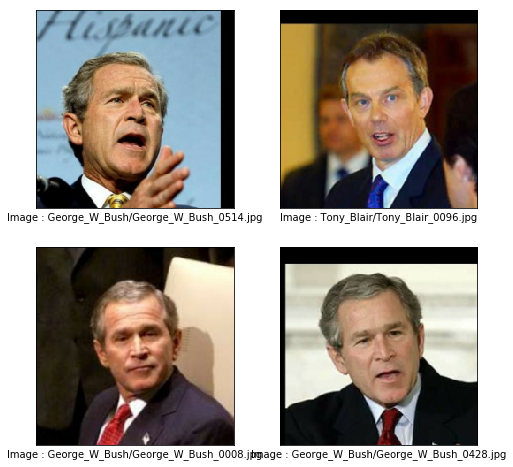

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))

In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [32]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

George_W_Bush
Tony_Blair
George_W_Bush
George_W_Bush
George_W_Bush
Arnold_Schwarzenegger
Junichiro_Koizumi
George_W_Bush
George_W_Bush
George_W_Bush


In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [37]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (224, 224, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


## Dataset split

In [0]:
train_addrs = addrs[0:int(0.6*len(addrs))]
train_labels = labels[0:int(0.6*len(labels))]
val_addrs = addrs[int(0.6*len(addrs)):int(0.8*len(addrs))]
val_labels = labels[int(0.6*len(addrs)):int(0.8*len(addrs))]
test_addrs = addrs[int(0.8*len(addrs)):]
test_labels = labels[int(0.8*len(labels)):]

In [0]:
datalen=len(all_image_paths)*0.6

In [0]:
#split data set
train_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[0:int(datalen*0.6)], all_image_labels[0:int(datalen*0.6)]))
val_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[int(datalen*0.6):int(datalen*0.8)], all_image_labels[int(datalen*0.6):int(datalen*0.8)]))
test_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[int(datalen*0.8):int(datalen)], all_image_labels[int(datalen*0.8):int(datalen)]))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

train_label_ds = train_ds.map(load_and_preprocess_from_path_label)
val_label_ds = train_ds.map(load_and_preprocess_from_path_label)
test_label_ds = test_ds.map(load_and_preprocess_from_path_label)

In [72]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
train_ds = train_ds.shuffle(buffer_size=img_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.shuffle(buffer_size=img_count)
val_ds = val_ds.repeat()
val_ds = val_ds.batch(BATCH_SIZE)



# `prefetch` lets the dataset fetch batches, in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print(train_ds)
print(val_ds)

<DatasetV1Adapter shapes: ((?, ?, 224, 224, 3), (?, ?)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.string, tf.int32)>


In [74]:
train_ds=train_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=int(img_count*0.6)))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
print(train_ds)
    
val_ds=val_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=int(img_count*0.2)))
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
print(val_ds)

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>


# Train phase

## Model setting

In [0]:
inception_net = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False)
inception_net.trainable=False

In [0]:
def chage_range(image,label):
    return 2*image-1, label
  
keras_ds =train_ds.map(chage_range)

In [0]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [78]:
feature_map_batch = inception_net(image_batch)
print(feature_map_batch.shape)

(32, 5, 5, 2048)


In [0]:
model = tf.keras.Sequential([
  inception_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [80]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -0.8174213
max logit: 2.3299882

Shape: (32, 5)


## Optimizer setting

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [82]:
len(model.trainable_variables) 

2

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [89]:
steps_per_epoch=tf.ceil(int(len(all_image_paths)*0.6)/BATCH_SIZE).numpy()
val_step=tf.ceil(int(len(all_image_paths)*0.2)/BATCH_SIZE).numpy()

print(steps_per_epoch)
initial_epochs=3

16.0


In [91]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds,
                    validation_steps=val_step,
                    )

Epoch 1/3
16/16 [==============================] - 83s 5s/step - loss: 2.7208 - acc: 0.6113 - val_loss: 3.0270 - val_acc: 0.6354
Epoch 2/3
16/16 [==============================] - 78s 5s/step - loss: 2.7506 - acc: 0.6074 - val_loss: 3.0265 - val_acc: 0.6354
Epoch 3/3
16/16 [==============================] - 79s 5s/step - loss: 2.6587 - acc: 0.6055 - val_loss: 3.0294 - val_acc: 0.6302


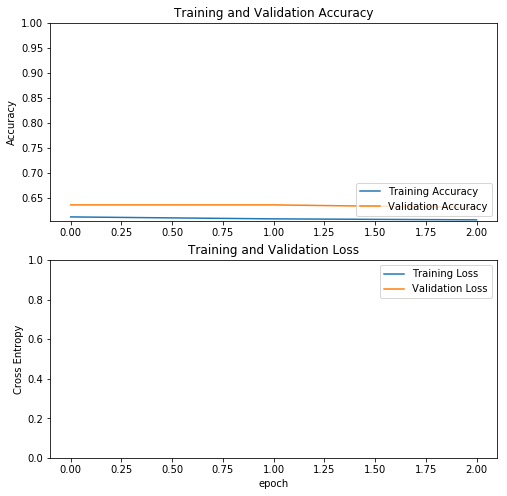

In [93]:
acc = history.history["acc"]
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## To do

image augmentation<br>


model save (.yaml)<br>

weight save (.checkpoint or hdfs)